### Programming Assignment 5
# **Linear Regression**

AJ Dave A. Obis and Juan Francis C. Tuatis

## Import the libraries to be used


In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

# **General Guidelines**
## 1. Load and perform exploratory data analysis

In [32]:
data = pd.read_csv("cyber_attacks(in).csv")

# Transform the data to DataFrame
data_df = pd.DataFrame(data)

# Print the first few rows of the DataFrame
data_df.head()


,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,Botnet
1,1,8.587924,409.971403,710.745376,17,6,Normal
2,1,4.386891,418.478693,559.457816,17,5,Normal
3,0,NaN,NaN,NaN,11,3,Normal
4,0,1.061892,494.253699,572.459614,11,3,Normal


### Check the Dataset Contents

In [17]:
# Check number of rows and columns in the DataFrame
print("Number of rows: ", data_df.shape[0])
print("Number of columns: ", data_df.shape[1])

Number of rows:  10000
Number of columns:  7


In [18]:
# Check if there are missing values in the dataset
missing_values = data_df.isnull().sum()
print("Missing values:\n", + missing_values)

Missing values:
 protocol_type        0
duration           500
src_bytes          500
dst_bytes          500
num_packets          0
num_connections      0
attack_type          0
dtype: int64


Looking at the distribution of the dataset with missing values,

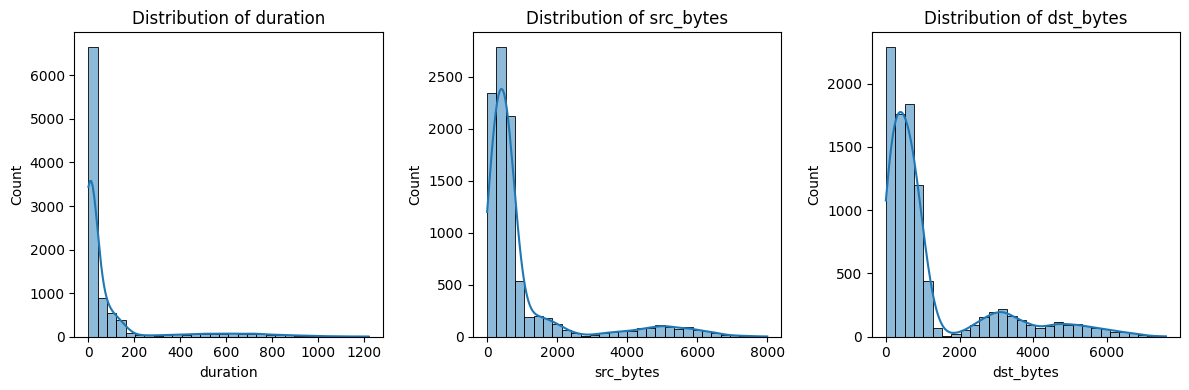

In [6]:
# Visualize distributions of affected numerical features
numerical_features = ['duration', 'src_bytes', 'dst_bytes']

# Plot histograms for missing value analysis
plt.figure(figsize=(12, 4))
for i, feature in enumerate(numerical_features):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data_df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

we can say that the data is right-skewed therefore highly variable.

### Attack Type Frequency/Distribution

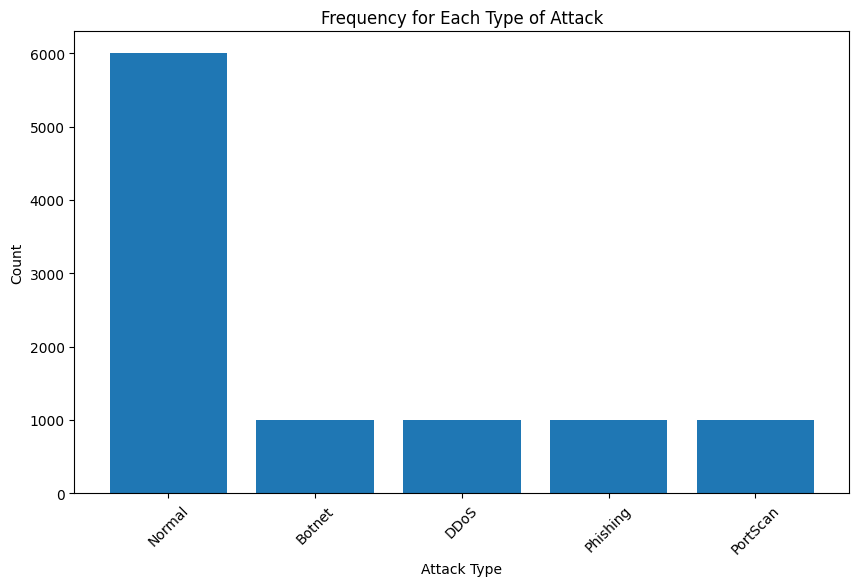

In [7]:
attack_counts = data_df['attack_type'].value_counts().reset_index()
attack_counts.columns = ['attack_type', 'count']

# Plot the attack counts
plt.figure(figsize=(10,6))
plt.bar(attack_counts['attack_type'], attack_counts['count'])

plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.title('Frequency for Each Type of Attack')

plt.xticks(rotation=45)
plt.show()

### Dataset Features Distribution

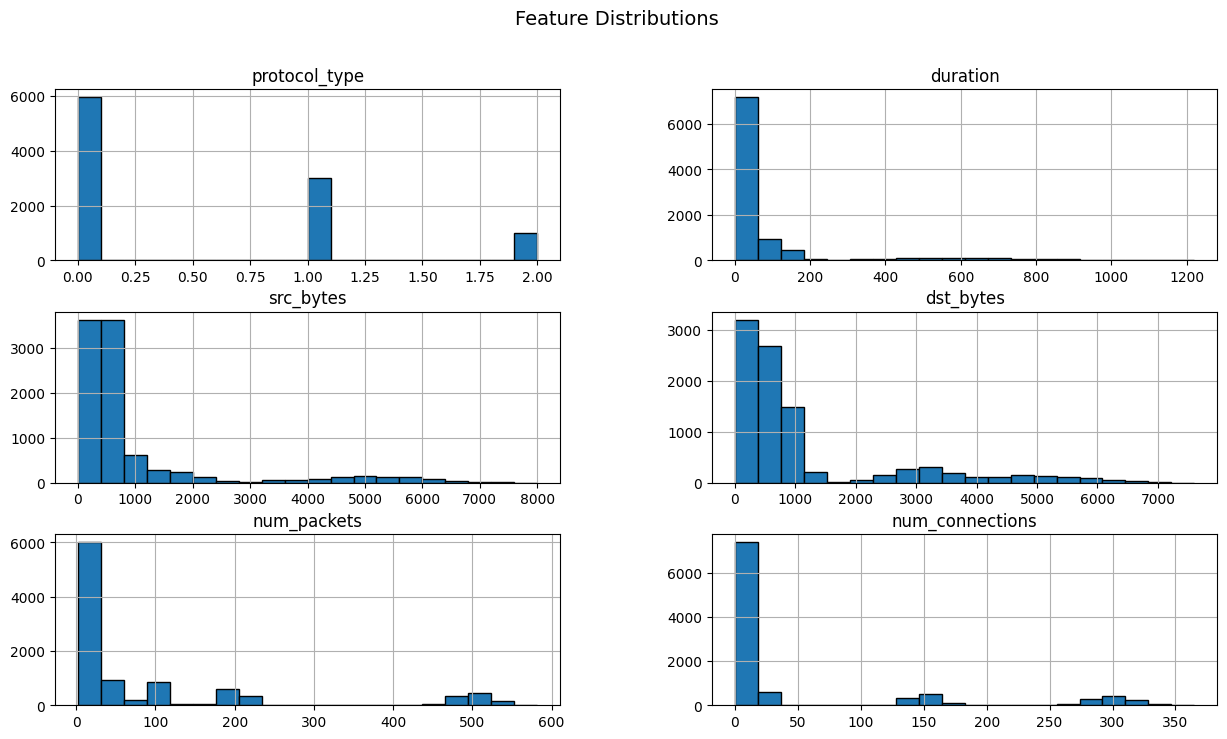

In [8]:
data_df.hist(figsize=(15, 8), bins=20, edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

## 2. Perform data preprocessing.

### Handling missing values
To address the missing values as observed from from our EDA, we implemented median imputation which is effective for highly variable dataset and extreme values to avoid distortion.

In [33]:
# Apply median imputation
imputer = SimpleImputer(strategy="median")
data_df[['duration', 'src_bytes', 'dst_bytes']] = imputer.fit_transform(data_df[['duration', 'src_bytes', 'dst_bytes']])

# show head
data_df.head()

,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,Botnet
1,1,8.587924,409.971403,710.745376,17,6,Normal
2,1,4.386891,418.478693,559.457816,17,5,Normal
3,0,7.121187,500.910972,598.294521,11,3,Normal
4,0,1.061892,494.253699,572.459614,11,3,Normal


In [34]:
# Check if there are still missing values in the dataset
missing_values = data_df.isnull().sum()
print("Missing values:\n", + missing_values)

Missing values:
 protocol_type      0
duration           0
src_bytes          0
dst_bytes          0
num_packets        0
num_connections    0
attack_type        0
dtype: int64


### Encoding categorical variable/feature (eg. protocol_type)

Encoding the 'protocol_type' feature

In [35]:
# Display the unique values in the categorical column
print("Unique values in protocol_type:", data_df['protocol_type'].unique())

# Perform one-hot encoding on the protocol_type column
data_df = pd.get_dummies(data_df, columns=['protocol_type'], drop_first=True)

# Display the first few rows of the encoded dataset
print("\nDataset after one-hot encoding:")
print(data_df.head())

Unique values in protocol_type: [1 0 2]

Dataset after one-hot encoding:
    duration    src_bytes   dst_bytes  num_packets  num_connections  \
0  43.418651  1701.411601  201.794741           42               15   
1   8.587924   409.971403  710.745376           17                6   
2   4.386891   418.478693  559.457816           17                5   
3   7.121187   500.910972  598.294521           11                3   
4   1.061892   494.253699  572.459614           11                3   

  attack_type  protocol_type_1  protocol_type_2  
0      Botnet             True            False  
1      Normal             True            False  
2      Normal             True            False  
3      Normal            False            False  
4      Normal            False            False  


Encoding the 'attack_type' feature

In [36]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding on the attack_type column
enc = LabelEncoder()
data_df['attack_type'] = enc.fit_transform(data_df['attack_type'])
display(data_df.head())

label_mapping = {index: class_label for index, class_label in enumerate(enc.classes_)}
print(label_mapping)

,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type,protocol_type_1,protocol_type_2
0,43.418651,1701.411601,201.794741,42,15,0,True,False
1,8.587924,409.971403,710.745376,17,6,2,True,False
2,4.386891,418.478693,559.457816,17,5,2,True,False
3,7.121187,500.910972,598.294521,11,3,2,False,False
4,1.061892,494.253699,572.459614,11,3,2,False,False


{0: 'Botnet', 1: 'DDoS', 2: 'Normal', 3: 'Phishing', 4: 'PortScan'}


### Handle class imbalance

Looking at the distribution of the attack_type feature and its classes from our EDA, we can see that it is skewed giving favor to the "Normal" class. This could lead to a biased model. To solve this we performed oversampling and used the 'class_weight' parameter in training the Random Forest Classifier.

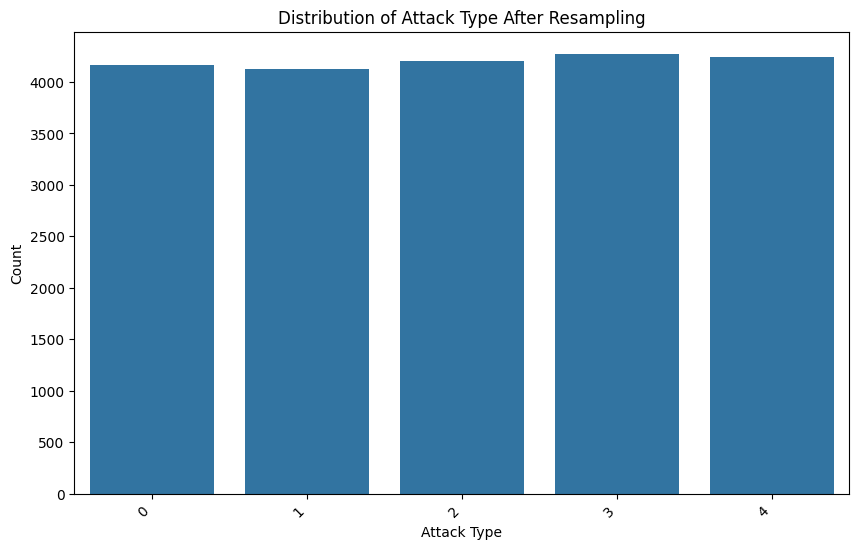

In [46]:
from sklearn.utils import resample
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# define variables
X, y = data_df.drop(columns=['attack_type']), data_df['attack_type']

# split the samples into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=30)
train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data['attack_type'] == 2]
minority_classes = train_data[train_data['attack_type'] != 2]

# Oversample the minority classes
minority_upsampled = resample(
    minority_classes,
    replace=True,
    n_samples=len(majority_class) * 4,
    random_state=30
)

# Combine majority and upsampled minority classes
balanced_data = pd.concat([majority_class, minority_upsampled]).sample(frac=1, random_state=30).reset_index(drop=True)

# Separate features and labels again
X_train_resampled = balanced_data.drop(columns=['attack_type'])
y_train_resampled = balanced_data['attack_type']

# check distribution of attack type
plt.figure(figsize=(10, 6))
sns.countplot(x='attack_type', data=balanced_data)
plt.title('Distribution of Attack Type After Resampling')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

## 3. Train a Random Forest Classifier using the preprocessed data to train the model.

In [47]:
# Train the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=3, class_weight='balanced', random_state=30, max_depth=3)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)

## 4. Perform feature importance analysis.

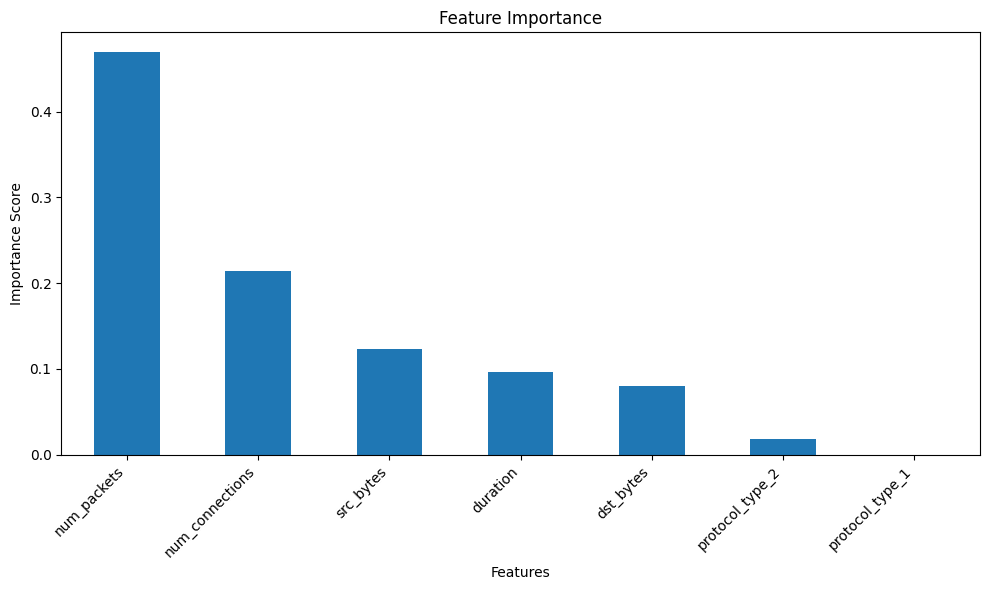

Feature Importances:
 num_packets        4.688136e-01
num_connections    2.140214e-01
src_bytes          1.228547e-01
duration           9.665498e-02
dst_bytes          7.981164e-02
protocol_type_2    1.784375e-02
protocol_type_1    6.607581e-17
dtype: float64


In [49]:
# Get feature importances from the trained model
importances = clf.feature_importances_

# Create a pandas Series for easier handling
feature_importances = pd.Series(importances, index=X_train_resampled.columns)

# Sort feature importances in descending order
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
feature_importances_sorted.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Print the feature importances
print("Feature Importances:\n", feature_importances_sorted)

## 5. Evaluate the model performance and report precision, recall, and F1-score. 

In [50]:
# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

# Balanced Accuracy Score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy Score: {balanced_acc:.4f}")

,precision,recall,f1-score,support
0,0.940063,0.993333,0.965964,300.000
1,1.000000,1.000000,1.000000,300.000
2,1.000000,0.999444,0.999722,1800.000
3,0.993151,0.966667,0.979730,300.000
4,1.000000,0.973333,0.986486,300.000
accuracy,0.993000,0.993000,0.993000,0.993
macro avg,0.986643,0.986556,0.986381,3000.000
weighted avg,0.993321,0.993000,0.993051,3000.000


Balanced Accuracy Score: 0.9866


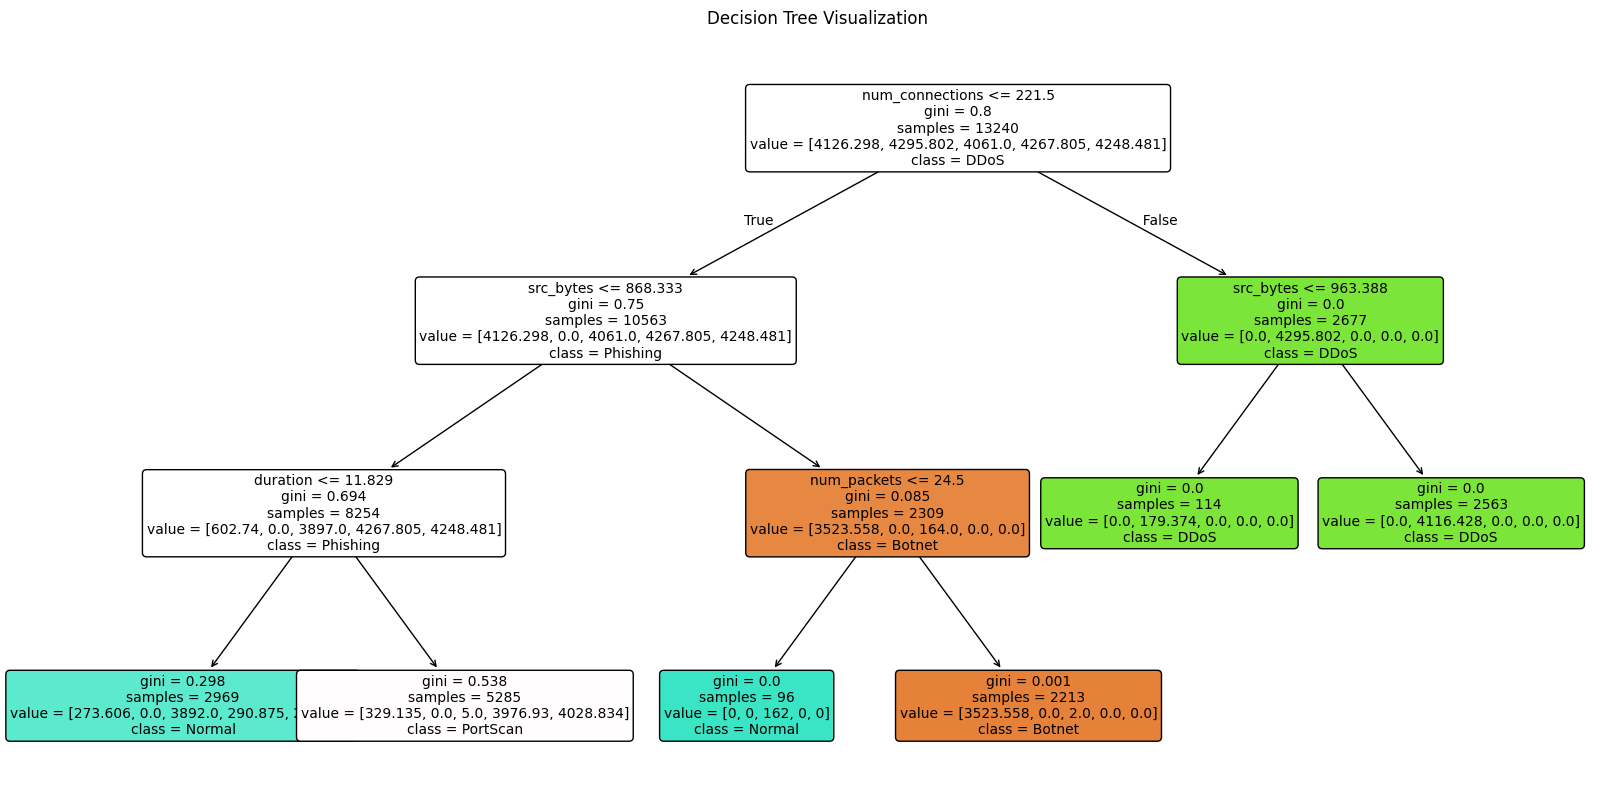

In [53]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract a single tree from the RandomForestClassifier
estimator = clf.estimators_[0]  # Get the first tree

# Define class names mapping
class_names_mapping = {0: 'Botnet', 1: 'DDoS', 2: 'Normal', 3: 'Phishing', 4: 'PortScan'}

# Get class names in the desired order
class_names = [class_names_mapping[i] for i in range(len(class_names_mapping))]

# Plot the tree
plt.figure(figsize=(20, 10))  # Adjust figure size as needed
plot_tree(estimator, 
          feature_names=X_train_resampled.columns, 
          class_names=class_names,  # Use the mapped class names
          filled=True, 
          rounded=True, 
          fontsize=10) 
plt.title("Decision Tree Visualization")
plt.show()

## Guide Questions 

### 1. Preprocessing
### How did you handle missing values in numerical features?

Missing values were dealt with the use of SimpleImputer and median values. SimpleImputer(strategy = 'median') is used to handle the missing values effeciently. Furthermore, median was used since the data are skewed, and median is less sensitive to extreme values or outliers. 

### Why is there a need to encode protocol_type feature, and which encoding method can be used?

The protocol_type feature needs to be encoded because it is a categorical variable. One-hot encoding is used here because it creates a new binary feature for each unique value in the protocol_type feature. This allows the model to understand that the values are not ordinal, but categorical.

### 2. Model Training 
### How did you adddress class imbalance in the dataset?

Class imbalance was handled using random oversampling using the "resample()" function. Then it was divded into 2 class, the minority and majority class. The minority class were oversampled to have a number of instances comparable to the majority class. Furthermore, "class_weight="balanced"" was used as another parameter in the model to adjust for the imbalanced classes durin the model training.

### What hyperparameters of the Random Forest did you tune, and why?

For the hyperparameter tuning it was done on "n_estimators", "min_samples_split", "min_samples_leaf" and "bootstrap". The tuning of parameters was done to avoid the model from being overfitted and to find the better performance of the model without being overly fitted.

### Why is a pipeline useful for this task?

A pipeline is useful in this task because it allows for the seamless integration of multiple preprocessing steps and the final estimator into a single object. This makes it easy to train the model, make predictions, and evaluate it all in a single step.

### 3. Evaluation
### Why is accuracy alone insufficient to evaluate this model?
Accuracy alone is an insufficient metric to evaluate this model especially in the case of skewed datasets, as in our case, since the model can achieve high accuracy rates by favoring the majority class while disregarding the minority classes. Metrics like precision, recall, F1-score, and balanced accuracy provide a better evaluation of performance.

### Which attack type was hardest to classify, and why might this be?
The attack type that was hardest to classify was the 'Botnet' attack since it is the one with the lowest classifaction report scores particularly in precision and F1-score. This is mainly because this attack type has the fewest instance in the dataset therefore the model struggles to identify significant patterns and chanes of mistakes are higher. Not to mention its similar features with other types.

### How would you improve the model’s performance on minority classes?
To improve the model's performance on minority classes, techniques like oversampling which is done in our case, can be implemented to obtain a balanced training set. Additionally, using the balanced 'class_weight' parameter in training the Random Forest Classifier also helps.

### 4. Interpretation
### Which features were most important for classification? Does this align with real-world attack patterns?
The most important feature for classification is num_packets, followed by num_connections, with much higher importance scores than the remaining features. This aligns with real-world attack patterns since network-based attacks, such as DDoS or port scanning, usually have an abnormal number of packets and connections. Other attributes like src_bytes and duration also have an effect but to a much lower extent.

### How would you explain the model’s decision-making process to a non-technical team?
To explain the decision-making process of the model to a non-technical team, visualization methods such as decision trees, which is also available in our model, or feature importance plots may be employed to describe how various network parameters influence class predictions. We can also tell them how certain classes are classified according to certain parameters and by giving them analogy like how music are classified to certain genres.

### 5. Application
### What steps would you take to deploy this model in a real-time network monitoring system?
To deploy this model in a real-time network monitoring system, we can implement it by converting the trained model into an API using frameworks like Flask or FastAPI. Then, it can be integrated into a real-time monitoring framework via streaming platforms to monitor network traffic in real time. For scalability and performance, the model can be run on cloud platforms or deployed at the network edge. Moreoever, notifications or alert messages can be implemented to inform security teams of threats found.

### How would you handle new attack types not present in the training data?
As cyber attacks types keep evolving, the model should be updated periodically with the datasets of these new attacks and by continuous learning. In addition, supervised classification and anomaly detection could assist in detecting new patterns of new attacks. Of course, keeping it in check by a human professional will ensure that threats are properly classified and help add into future training datasets.